In [1]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer, MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
apple = pd.read_csv('Data/AAPL_2006-01-01_to_2018-01-01.csv', index_col = 'Date', parse_dates=['Date'])

In [3]:
apple.head(10)

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL
2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL
2006-01-05,10.69,10.70,10.54,10.63,112396081,AAPL
2006-01-06,10.75,10.96,10.65,10.90,176139334,AAPL
2006-01-09,10.96,11.03,10.82,10.86,168861224,AAPL
2006-01-10,10.89,11.70,10.83,11.55,570088246,AAPL
2006-01-11,11.98,12.11,11.80,11.99,373548882,AAPL
2006-01-12,12.14,12.34,11.95,12.04,320201966,AAPL
2006-01-13,12.14,12.29,12.09,12.23,194153393,AAPL


In [4]:
apple.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3019 entries, 2006-01-03 to 2017-12-29
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3019 non-null   float64
 1   High    3019 non-null   float64
 2   Low     3019 non-null   float64
 3   Close   3019 non-null   float64
 4   Volume  3019 non-null   int64  
 5   Name    3019 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 165.1+ KB


In [5]:
np.sum(apple.isna(), axis = 0)

Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64

In [6]:
def plot_stocks(column):
    for i in range(2006, 2018):
        apple[str(i)][column].asfreq('d').plot()
    plt.title(f"{column}")
    plt.show()

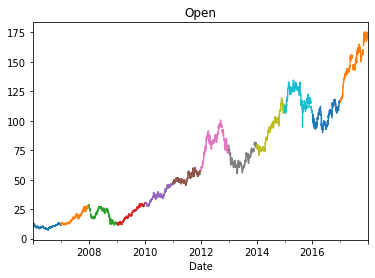

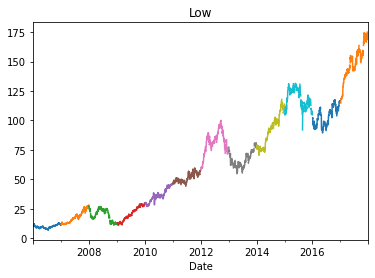

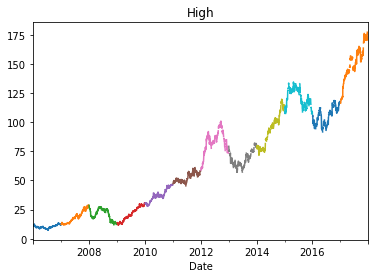

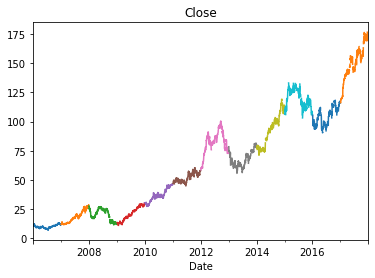

In [7]:
plot_stocks("Open")
plot_stocks("Low")
plot_stocks("High")
plot_stocks("Close")

In [8]:
def plot_roll(column):
    rolling = apple[f"{column}"].rolling('100d').mean()
    apple[f"{column}"].plot(color = 'green')
    rolling.plot(color = 'yellow')
    plt.legend([f'{column}', f'Rolling Mean of {column} over a 100 days'])
    plt.show()

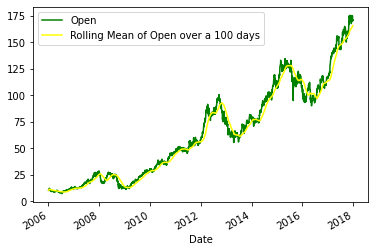

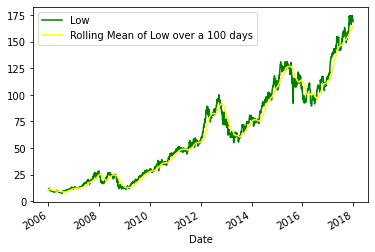

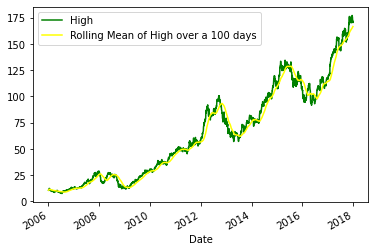

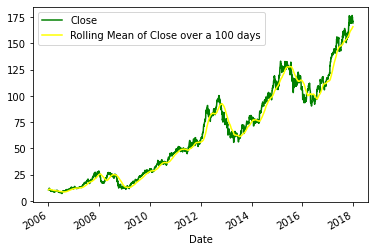

In [9]:
plot_roll("Open")
plot_roll("Low")
plot_roll("High")
plot_roll("Close")

In [10]:
def scale_data(train, column):
    
    sc = MinMaxScaler(feature_range=(0,1))
    train_data = train[column]
    
    train_prep = np.array([train_data.to_list()]).T
    train_norm = sc.fit_transform(train_prep)
    
    return train_norm

In [29]:
sc = MinMaxScaler(feature_range=(0, 1))
def load_data(datasetname, column, seq_len, days):

    data = datasetname.loc[:,column]
    sequence_length = seq_len + 1
    result = []

    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    result = normalise_data(result)
    result = np.array(result)

    val_split = round(0.9 * result.shape[0])
    train = result[:int(val_split), :]
    
    X_train = train[:, :-days]
    y_train = train[:, -days:]
    X_test = result[int(val_split):, :-days]
    y_test = result[int(val_split):, -days:]

    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)) 


    return [X_train, y_train, X_test, y_test]

def normalise_data(data):

    normalised_data = []
    for stock in data:
        normalised = [((float(p) / float(stock[0])) - 1) for p in stock]
        normalised_data.append(normalised)
    return normalised_data


In [30]:
X_train, y_train, X_test, y_test = load_data(apple, "Open", 100, 1)

In [31]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2626, 100, 1), (2626, 1), (292, 100, 1), (292, 1))

In [32]:
def create_model(shape):
    
    model = tf.keras.models.Sequential()
    
    model.add(tf.keras.layers.LSTM(30, return_sequences = True, input_shape = (shape, 1)))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.LSTM(45, return_sequences = True))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.LSTM(50, return_sequences = False))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(14, activation = 'linear'))
    
    return model

In [33]:
model = create_model(X_train.shape[1])

In [34]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100, 30)           3840      
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 30)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 45)           13680     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100, 45)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                19200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 14)               

In [35]:
model.compile(loss = 'mse', optimizer = 'Adam')

In [45]:
def train_predict(dataset, model, name, sequence, days):
    
    """
    model: model used for training
    name: Name of stock characteristic
    sequence: Number of prior days to take into account
    days: Prediction days
    """
    
    X_train, y_train, X_test, y_test = load_data(dataset, name, sequence, days)
    
    model.fit(X_train, y_train, batch_size = 64, epochs = 45, validation_data = (X_test, y_test))
    
    test_preds = model.predict(X_test)
    
    plt.title(f"Real (Red) vs Predictions(Blue): {name} (Normalized)")
    p1 = plt.plot(y_test, color = 'r')
    p2 = plt.plot(test_preds, color = 'c')
    
    

Epoch 1/45
42/42 [==============================] - 1s 18ms/step - loss: 0.0044 - val_loss: 0.0014
Epoch 2/45
42/42 [==============================] - 0s 11ms/step - loss: 0.0044 - val_loss: 0.0012
Epoch 3/45
42/42 [==============================] - 0s 11ms/step - loss: 0.0052 - val_loss: 0.0013
Epoch 4/45
42/42 [==============================] - 0s 11ms/step - loss: 0.0044 - val_loss: 0.0015
Epoch 5/45
42/42 [==============================] - 0s 11ms/step - loss: 0.0046 - val_loss: 0.0013
Epoch 6/45
42/42 [==============================] - 0s 11ms/step - loss: 0.0044 - val_loss: 0.0013
Epoch 7/45
42/42 [==============================] - 0s 11ms/step - loss: 0.0043 - val_loss: 0.0012
Epoch 8/45
42/42 [==============================] - 0s 11ms/step - loss: 0.0044 - val_loss: 0.0013
Epoch 9/45
42/42 [==============================] - 0s 11ms/step - loss: 0.0044 - val_loss: 0.0013
Epoch 10/45
42/42 [==============================] - 0s 11ms/step - loss: 0.0044 - val_loss: 0.0013
Epoch 11/

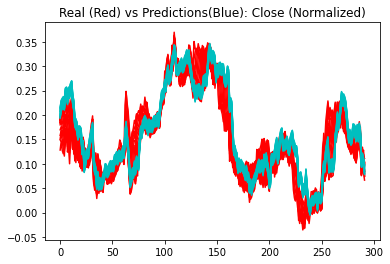

In [46]:
train_predict(apple, model, "Close", 100, 14)

Epoch 1/45
42/42 [==============================] - 0s 12ms/step - loss: 0.0041 - val_loss: 0.0013
Epoch 2/45
42/42 [==============================] - 0s 11ms/step - loss: 0.0040 - val_loss: 0.0013
Epoch 3/45
42/42 [==============================] - 0s 11ms/step - loss: 0.0040 - val_loss: 0.0012
Epoch 4/45
42/42 [==============================] - 0s 11ms/step - loss: 0.0041 - val_loss: 0.0013
Epoch 5/45
42/42 [==============================] - 0s 11ms/step - loss: 0.0040 - val_loss: 0.0012
Epoch 6/45
42/42 [==============================] - 0s 11ms/step - loss: 0.0040 - val_loss: 0.0012
Epoch 7/45
42/42 [==============================] - 0s 10ms/step - loss: 0.0039 - val_loss: 0.0012
Epoch 8/45
42/42 [==============================] - 0s 11ms/step - loss: 0.0041 - val_loss: 0.0012
Epoch 9/45
42/42 [==============================] - 0s 11ms/step - loss: 0.0039 - val_loss: 0.0013
Epoch 10/45
42/42 [==============================] - 0s 11ms/step - loss: 0.0039 - val_loss: 0.0012
Epoch 11/

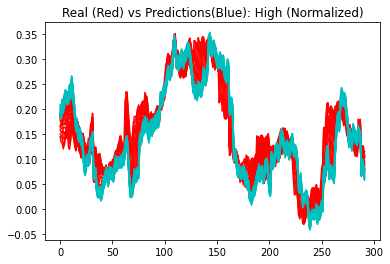

In [47]:
train_predict(apple, model, "High", 100, 14)

Epoch 1/45
42/42 [==============================] - 1s 12ms/step - loss: 0.0044 - val_loss: 0.0013
Epoch 2/45
42/42 [==============================] - 0s 11ms/step - loss: 0.0042 - val_loss: 0.0014
Epoch 3/45
42/42 [==============================] - 0s 11ms/step - loss: 0.0042 - val_loss: 0.0014
Epoch 4/45
42/42 [==============================] - 0s 11ms/step - loss: 0.0043 - val_loss: 0.0013
Epoch 5/45
42/42 [==============================] - 0s 11ms/step - loss: 0.0042 - val_loss: 0.0013
Epoch 6/45
42/42 [==============================] - 0s 11ms/step - loss: 0.0043 - val_loss: 0.0013
Epoch 7/45
42/42 [==============================] - 0s 11ms/step - loss: 0.0043 - val_loss: 0.0013
Epoch 8/45
42/42 [==============================] - 0s 11ms/step - loss: 0.0046 - val_loss: 0.0013
Epoch 9/45
42/42 [==============================] - 0s 11ms/step - loss: 0.0043 - val_loss: 0.0012
Epoch 10/45
42/42 [==============================] - 0s 11ms/step - loss: 0.0044 - val_loss: 0.0013
Epoch 11/

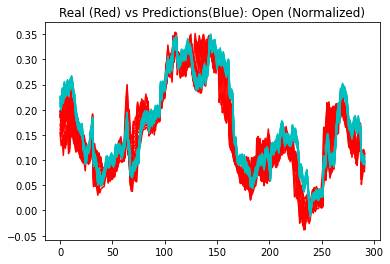

In [48]:
train_predict(apple, model, "Open", 100, 14)